# TX: Tensor Product Interaction with pre-optimization

This notebook shows an exmaple of how to use `liesel_gam.consolidate_bases` to turn weak basis matrix variables into strong ones - this can be necessary to avoid problems with callbacks to R, especially when trying to optimize for good starting values using `liesel.goose.optim_flat`.

## Setup and Imports

In [153]:
import jax.numpy as jnp
import liesel.goose as gs
import liesel.model as lsl
import matplotlib.pyplot as plt
import numpy as np
import plotnine as p9
import tensorflow_probability.substrates.jax.distributions as tfd

import liesel_gam as gam
from liesel_gam.consolidate_bases import consolidate_bases, evaluate_bases

In [154]:
df = gam.demo_data_ta(n=600, noise_sd=0.25, seed=42)
df_grid = gam.demo_data_ta(n=5000, grid=True)

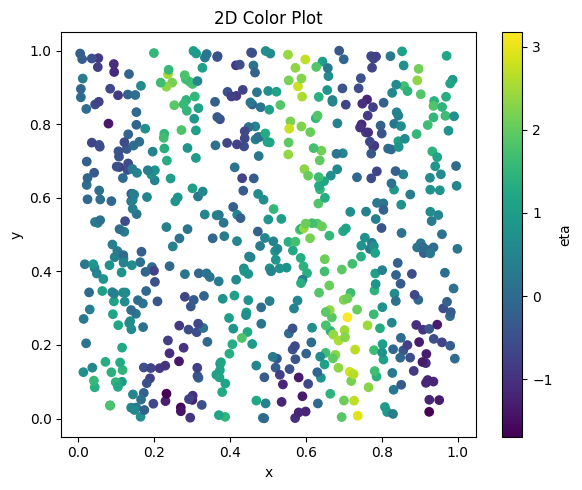

In [155]:
plt.figure(figsize=(6, 5))
plt.scatter(df["x"], df["y"], c=df["z"])
plt.xlabel("x")
plt.ylabel("y")
plt.title("2D Color Plot")
plt.colorbar(label="eta")
plt.tight_layout()
plt.show()

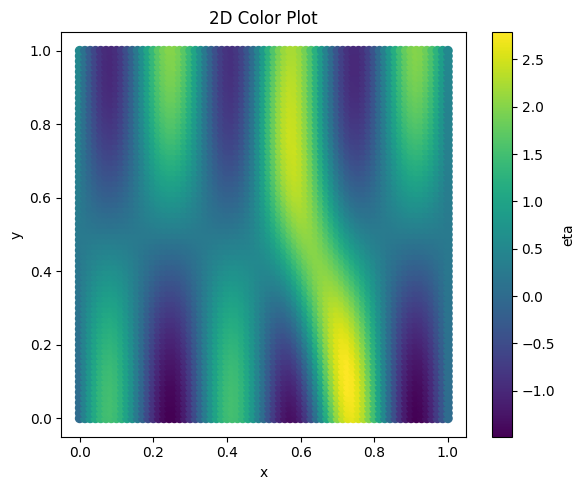

In [156]:
plt.figure(figsize=(6, 5))
plt.scatter(df_grid["x"], df_grid["y"], c=df_grid["eta"])
plt.xlabel("x")
plt.ylabel("y")
plt.title("2D Color Plot")
plt.colorbar(label="eta")
plt.tight_layout()
plt.show()

## Model Definition

### Setup response model

In [157]:
loc = gam.AdditivePredictor("$\\mu$")
scale = gam.AdditivePredictor("$\\sigma$", inv_link=jnp.exp)


z = lsl.Var.new_obs(
    value=df.z.to_numpy(),
    distribution=lsl.Dist(tfd.Normal, loc=loc, scale=scale),
    name="z",
)

In [158]:
import tensorflow_probability.substrates.jax.bijectors as tfb


def scale_fn():
    prior = lsl.Dist(
        tfd.HalfNormal,
        scale=jnp.array(20.0),
    )

    scale = lsl.Var.new_param(
        jnp.array(0.1),
        distribution=prior,
        name="{x}",  # {x} is a placeholder for the automatically generated name
    )

    scale.transform(
        tfb.Softplus(),
        inference=gs.MCMCSpec(gs.IWLSKernel.untuned),
        name="h({x})",  # {x} is a placeholder for the automatically generated name
    )
    return scale


tb = gam.TermBuilder.from_df(df, default_scale_fn=scale_fn)

In [159]:
loc += (
    tb.ps("x", k=20),
    tb.ps("y", k=20),
    tb.tx(
        tb.ps("x", k=10),
        tb.ps("y", k=10),
    ),
)

### Build and plot model

liesel.model.model - INFO - Converted dtype of Value(name="z_value").value


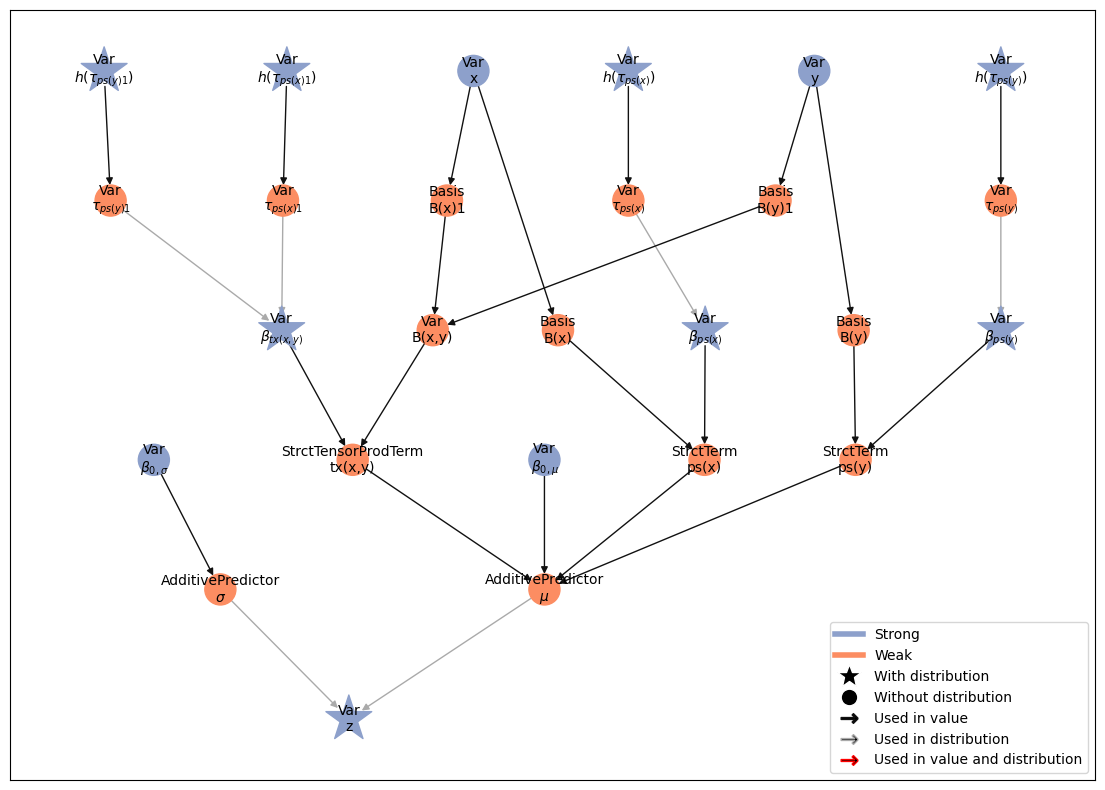

In [160]:
model = lsl.Model([z])
model.plot_vars()

In [161]:
model, bases_model = consolidate_bases(model)

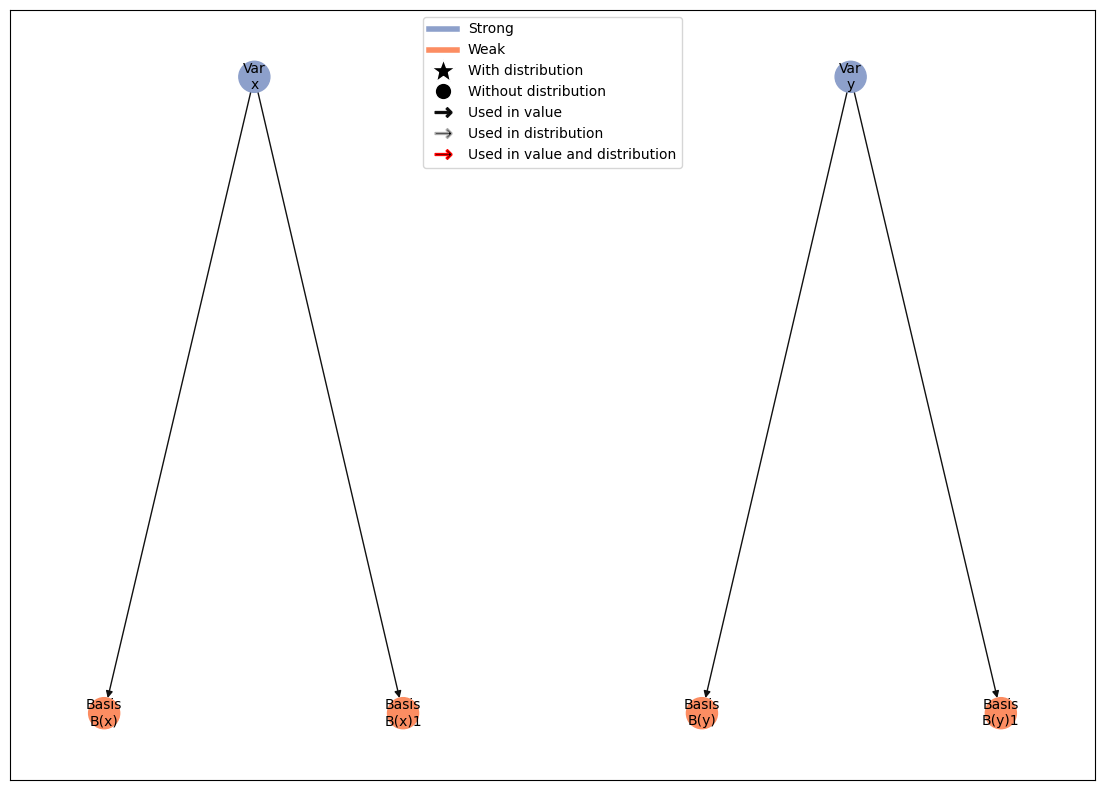

In [162]:
bases_model.plot_vars()

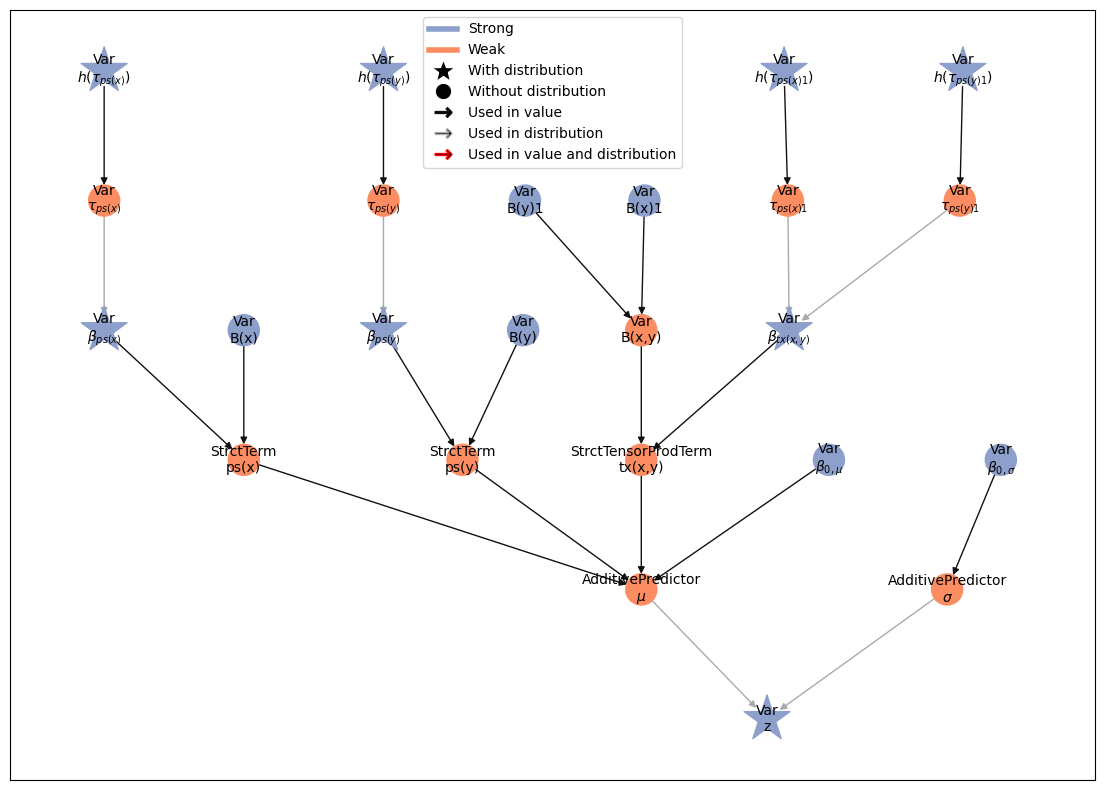

In [163]:
model.plot_vars()

In [164]:
import optax

params = [p.name for p in model.parameters.values() if not p.name.startswith("$\\tau")]

# this is the optimization
# I am being lazy here: Usually, convergence should be assessed.
opt = gs.optim_flat(
    model,
    params,
    optimizer=optax.adam(learning_rate=1e-3),
    progress_bar=False,
)

model.state = model.update_state(opt.position)

## Run MCMC

In [165]:
eb = gs.LieselMCMC(model).get_engine_builder(seed=1, num_chains=4)

eb.add_adaptation(2000)
eb.add_posterior(5000, thinning=5)

engine = eb.build()
engine.sample_all_epochs()
results = engine.get_results()

liesel.goose.builder - WARNING - No jitter functions provided for position keys '$h(\\tau_{ps(x)})$', '$\\beta_{ps(x)}$', '$h(\\tau_{ps(y)})$', '$\\beta_{ps(y)}$', '$h(\\tau_{ps(x)1})$', '$h(\\tau_{ps(y)1})$', '$\\beta_{tx(x,y)}$', '$\\beta_{0,\\mu}$', '$\\beta_{0,\\sigma}$'. The initial values for these keys won't be jittered
liesel.goose.engine - INFO - Initializing kernels...
liesel.goose.engine - INFO - Done
liesel.goose.engine - INFO - Starting epoch: FAST_ADAPTATION, 200 transitions, 25 jitted together
100%|██████████████████████████████████████████| 8/8 [00:13<00:00,  1.70s/chunk]
liesel.goose.engine - WARNING - Errors per chain for kernel_04: 4, 1, 3, 3 / 200 transitions
liesel.goose.engine - INFO - Finished epoch
liesel.goose.engine - INFO - Starting epoch: SLOW_ADAPTATION, 25 transitions, 25 jitted together
100%|█████████████████████████████████████████| 1/1 [00:00<00:00, 819.68chunk/s]
liesel.goose.engine - WARNING - Errors per chain for kernel_04: 0, 1, 0, 1 / 25 transition

### MCMC summary

In [166]:
summary = gs.Summary(results)

diagnostics = (
    summary.to_dataframe()
    .reset_index()
    .loc[:, ["variable", "rhat", "ess_bulk", "ess_tail"]]
    .groupby("variable", as_index=False)
    .agg(
        ess_bulk_min=("ess_bulk", "min"),
        ess_bulk_median=("ess_bulk", "median"),
        ess_tail_min=("ess_tail", "min"),
        ess_tail_median=("ess_tail", "median"),
        rhat_max=("rhat", "max"),
        rhat_median=("rhat", "median"),
    )
)
diagnostics

,variable,ess_bulk_min,ess_bulk_median,ess_tail_min,ess_tail_median,rhat_max,rhat_median
0,"$\beta_{0,\mu}$",3307.507975,3307.507975,3577.557442,3577.557442,1.002009,1.002009
1,"$\beta_{0,\sigma}$",918.366039,918.366039,2255.471602,2255.471602,1.001283,1.001283
2,$\beta_{ps(x)}$,1712.997026,2584.969387,2731.346476,3141.713481,1.001389,1.000966
3,$\beta_{ps(y)}$,546.610660,2569.339449,718.818928,1253.673204,1.010668,1.008388
4,"$\beta_{tx(x,y)}$",150.340189,1161.144110,422.045756,1315.808045,1.018642,1.003531
5,$h(\tau_{ps(x)1})$,1005.764434,1005.764434,412.597416,412.597416,1.005035,1.005035
6,$h(\tau_{ps(x)})$,1204.391135,1204.391135,2110.485263,2110.485263,1.000669,1.000669
7,$h(\tau_{ps(y)1})$,111.437076,111.437076,334.814216,334.814216,1.018971,1.018971
8,$h(\tau_{ps(y)})$,157.634193,157.634193,208.067725,208.067725,1.027667,1.027667


## Predictions

In [167]:
samples = results.get_posterior_samples()

In [168]:
newdata = {"x": df_grid.x.to_numpy(), "y": df_grid.y.to_numpy()}
newdata = evaluate_bases(newdata, bases_model)

### Predict variables at new x values

In [169]:
predictions = model.predict(
    samples=samples,
    predict=["tx(x,y)", "$\\mu$", "ps(x)", "ps(y)"],
    newdata=newdata,
)

predictions_summary = (
    gs.SamplesSummary(predictions, which=["mean", "quantiles"])
    .to_dataframe()
    .reset_index()
)

In [170]:
predictions_summary["x"] = np.tile(df_grid.x.to_numpy(), len(predictions))
predictions_summary["y"] = np.tile(df_grid.y.to_numpy(), len(predictions))

In [171]:
predictions_summary.head()

,variable,var_fqn,var_index,sample_size,mean,q_0.05,q_0.5,q_0.95,x,y
0,$\mu$,$\mu$[0],"(0,)",4000,-0.794277,-1.919930,-0.804964,0.356087,0.000000,0.0
1,$\mu$,$\mu$[1],"(1,)",4000,0.192279,-0.705666,0.190628,1.091368,0.014286,0.0
2,$\mu$,$\mu$[2],"(2,)",4000,0.934204,0.219105,0.930426,1.650856,0.028571,0.0
3,$\mu$,$\mu$[3],"(3,)",4000,1.442272,0.857040,1.448904,2.031990,0.042857,0.0
4,$\mu$,$\mu$[4],"(4,)",4000,1.740637,1.258972,1.745124,2.231986,0.057143,0.0


### Plot fitted functions

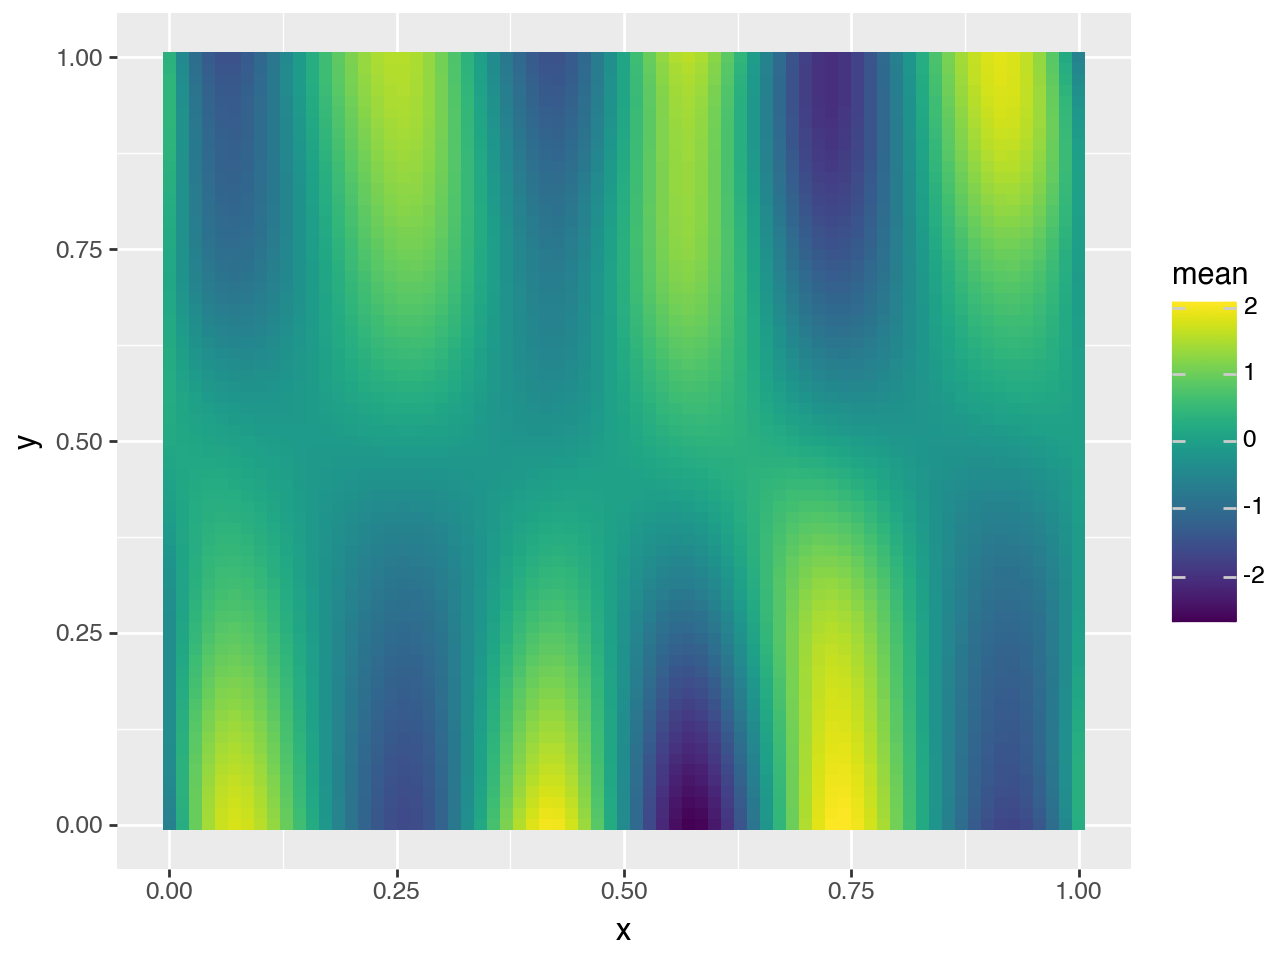

In [172]:
select = predictions_summary["variable"].isin(["tx(x,y)"])
(p9.ggplot(predictions_summary[select]) + p9.geom_tile(p9.aes("x", "y", fill="mean")))

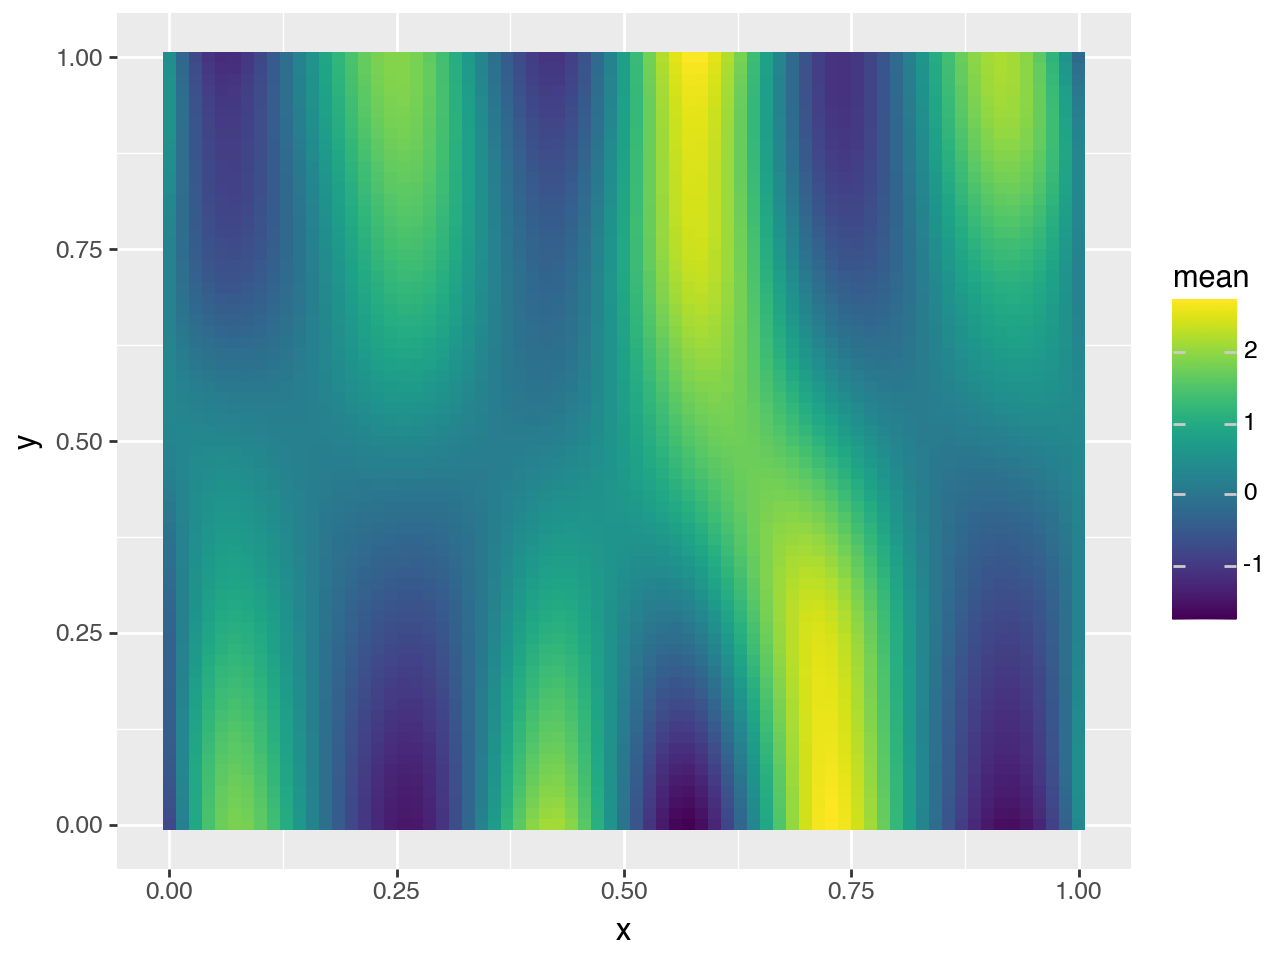

In [173]:
select = predictions_summary["variable"].isin(["$\\mu$"])
(p9.ggplot(predictions_summary[select]) + p9.geom_tile(p9.aes("x", "y", fill="mean")))

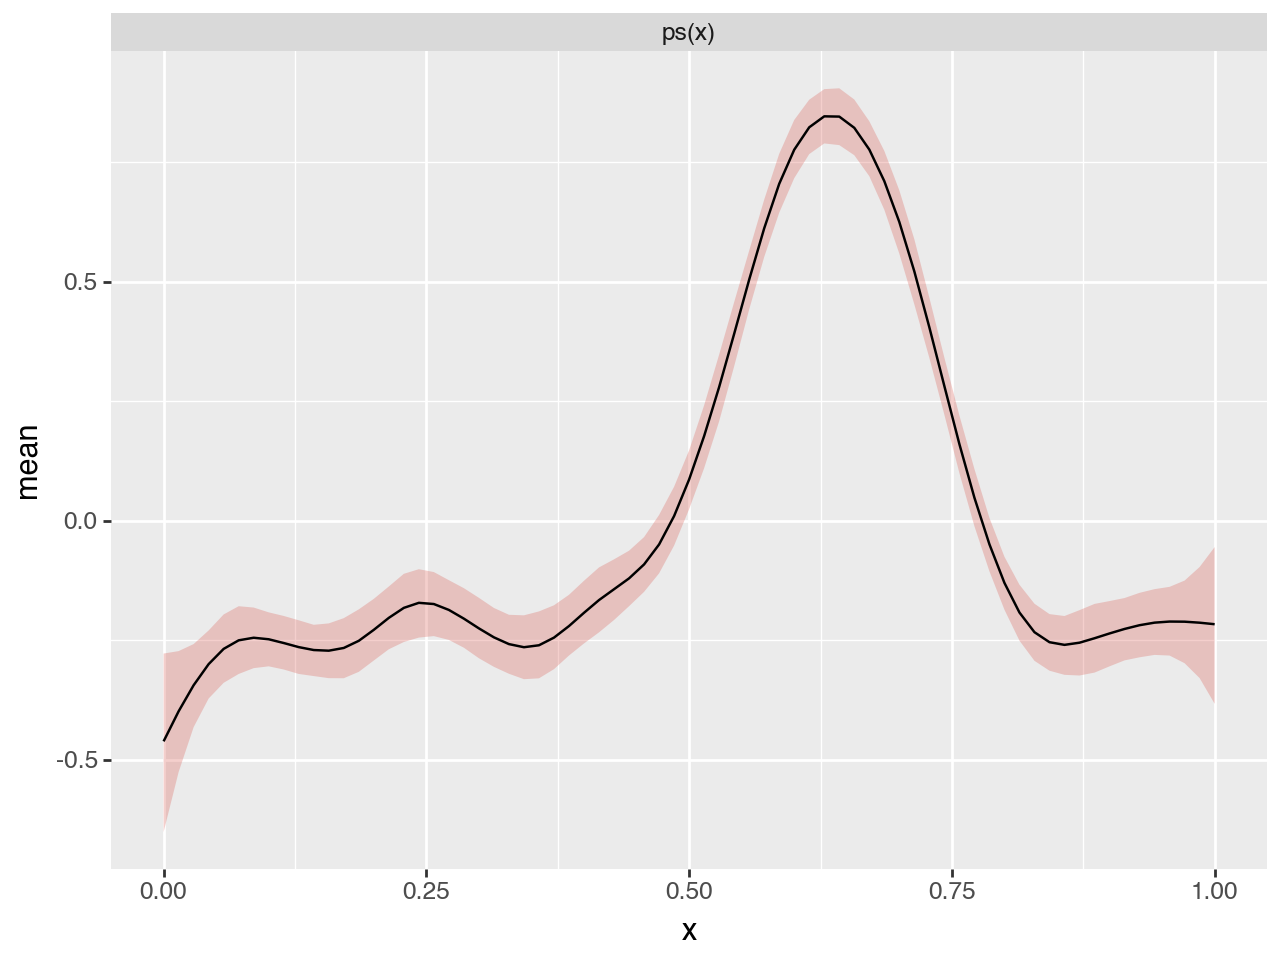

In [174]:
select = predictions_summary["variable"].isin(["ps(x)"])
(
    p9.ggplot(predictions_summary[select])
    + p9.geom_ribbon(
        p9.aes("x", ymin="q_0.05", ymax="q_0.95", fill="variable"), alpha=0.3
    )
    + p9.geom_line(p9.aes("x", "mean"))
    + p9.facet_wrap("~variable", scales="free_y", ncol=1)
    + p9.guides(fill="none")
)

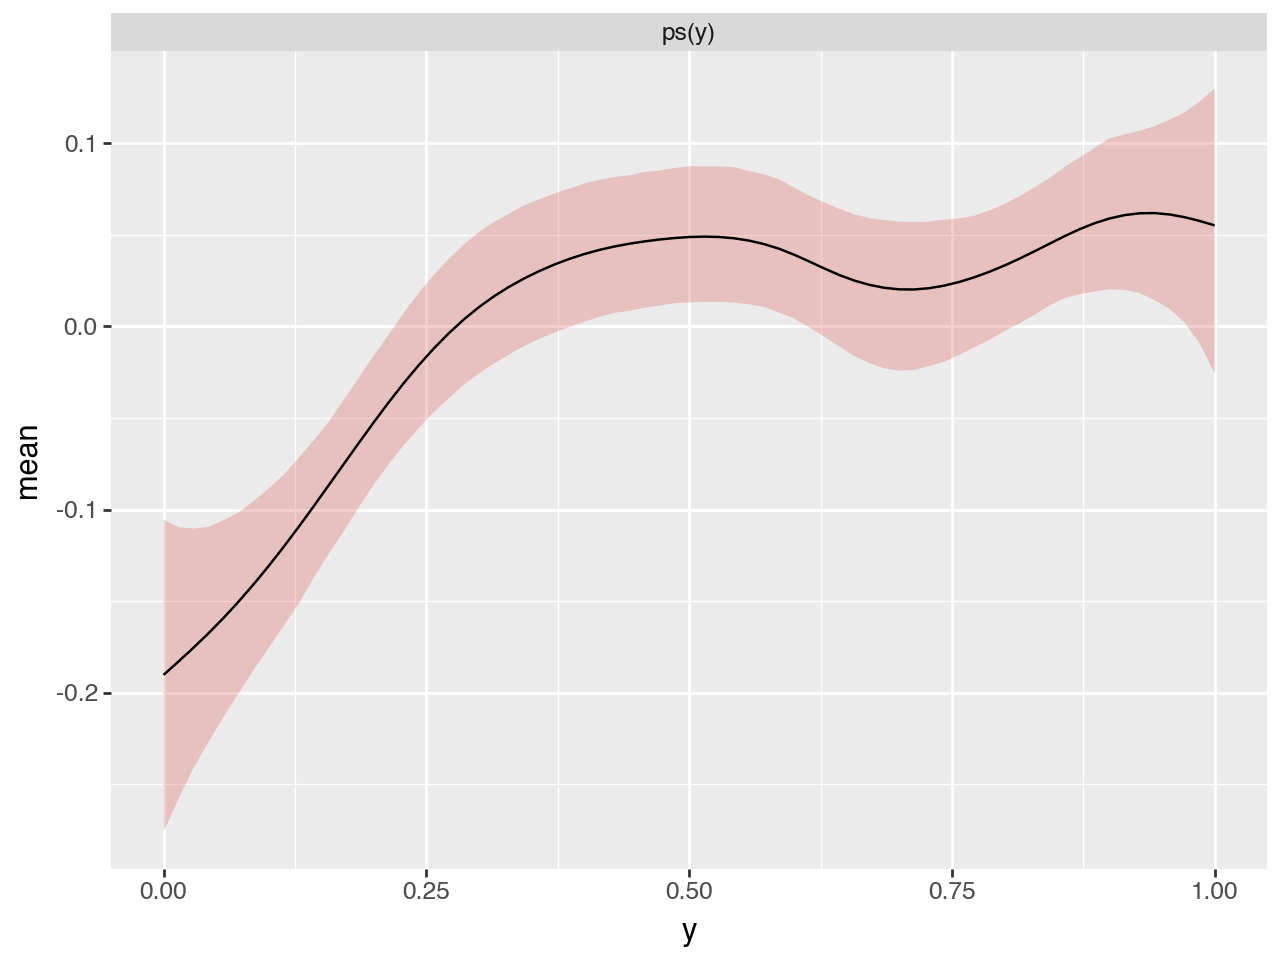

In [175]:
select = predictions_summary["variable"].isin(["ps(y)"])
(
    p9.ggplot(predictions_summary[select])
    + p9.geom_ribbon(
        p9.aes("y", ymin="q_0.05", ymax="q_0.95", fill="variable"), alpha=0.3
    )
    + p9.geom_line(p9.aes("y", "mean"))
    + p9.facet_wrap("~variable", scales="free_y", ncol=1)
    + p9.guides(fill="none")
)